In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ananthu017/emotion-detection-fer
! unzip emotion-detection-fer

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

Import Standard Libraries

In [3]:
import numpy as npy # linear algebra
import pandas as pds # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen

In [4]:
# Specify important directories
import os, sys, time, warnings, sklearn

TRAIN_PATH='/content/train'
TEST_PATH='/content/test'
# TRAIN_PATH=ROOT+'/fer-2013-images/train'
# TEST_PATH=ROOT+'/fer-2013-images/test'
train_angry_img_path=TRAIN_PATH +'/angry'

OVERSAMPLED_TRAIN_PATH='fed_oversampled_train'
MODEL_PATH='models'
IMAGE_PATH='images'

# Model Architecture path
def model_arch(model_name):
    # !mkdir -p images
    !mkdir images
    arch=IMAGE_PATH+'/fer-2013_'+model_name+'.png'
    return arch

#  TensorFlow Checkpoint save_weight uses .ckpt extension format
def checkpoint_path(model_name):
    # !mkdir models
    checkpoint_path = MODEL_PATH+"/fedav_best_model-"+model_name+".ckpt"
    return checkpoint_path


Exploratory Data Analysis

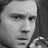

In [5]:
# Load a sample image
# using open() to open images
image_data = Image.open('/content/train/angry/im0.png')
image_data

Image shape: (48, 48)
Image data array: [[ 70  80  82 ...  52  43  41]
 [ 65  61  58 ...  56  52  44]
 [ 50  43  54 ...  49  56  47]
 ...
 [ 91  65  42 ...  72  56  43]
 [ 77  82  79 ... 105  70  46]
 [ 77  72  84 ... 106 109  82]]
Image array shape: (48, 48)


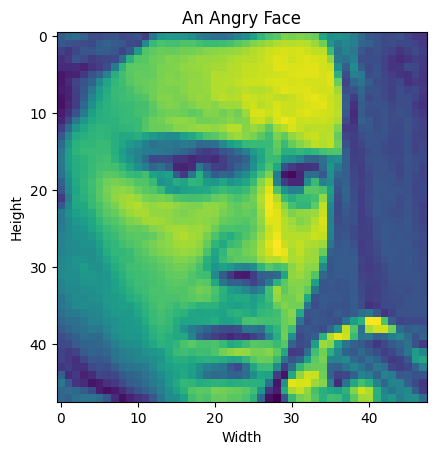

In [6]:
# Get the shape of the image
image=plt.imread(train_angry_img_path+'/im0.png')
print(f'Image shape: {image.shape}')

# Convert image data (like jpeg) to numpy using asarray()
image_array = npy.asarray(image_data)
print(f'Image data array: {image_array}')

# Get the shape of the image array
print(f'Image array shape: {image_array.shape}')

# Printing the image
plt.imshow(image_array)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('An Angry Face')
plt.show()

In [7]:
# Get the list of folders in the directory as classes
classes=os.listdir(TRAIN_PATH+'/')
classes

['neutral', 'happy', 'disgusted', 'angry', 'sad', 'surprised', 'fearful']

In [8]:
# Get dictionary list of image count per class
def class_sample(type):
    if type.lower() == 'test' or type.lower() == 'train':
        path=''
        if type.lower() == 'train':
            path= TRAIN_PATH
        else:
            path= TEST_PATH

        filepath=path+'/'
        class_count = []
        class_dict ={}
        for folder in os.listdir(filepath) :
              class_count.append(len(os.listdir(filepath+folder)))
              class_dict[folder]=len(os.listdir(filepath+folder))
        class_total = sum(class_count)
        return class_total, class_count, class_dict
    else:
        raise ValueError('Invalid type. Must be "test" or "train".')


def test_train_distribution():
      print("---- Train Set ----")
      avg_train=class_sample('train')[0]/len(class_sample('train')[1])
      print(f'Train class distribution:\n{class_sample("train")[2]}')
      print("Average train class: ",round(avg_train))
      print('Total train: ', class_sample('train')[0])

      print("\n---- Test Set ----")
      avg_test=class_sample('test')[0]/len(class_sample('test')[1])
      print(f'Test class distribution:\n{class_sample("test")[2]}')
      print("Average test class: ",round(avg_test))
      print('Total test: ', class_sample('test')[0])


test_train_distribution()

# test_samples=class_sample('test')[0]
# test_batch_size=sorted([int(test_samples/n) for n in range(1,test_samples+1) if test_samples % n ==0 and test_samples/n<=80],reverse=True)[0]

---- Train Set ----
Train class distribution:
{'neutral': 4965, 'happy': 7215, 'disgusted': 436, 'angry': 3995, 'sad': 4830, 'surprised': 3171, 'fearful': 4097}
Average train class:  4101
Total train:  28709

---- Test Set ----
Test class distribution:
{'neutral': 1233, 'happy': 1774, 'disgusted': 111, 'angry': 958, 'sad': 1247, 'surprised': 831, 'fearful': 1024}
Average test class:  1025
Total test:  7178


Data Visualization

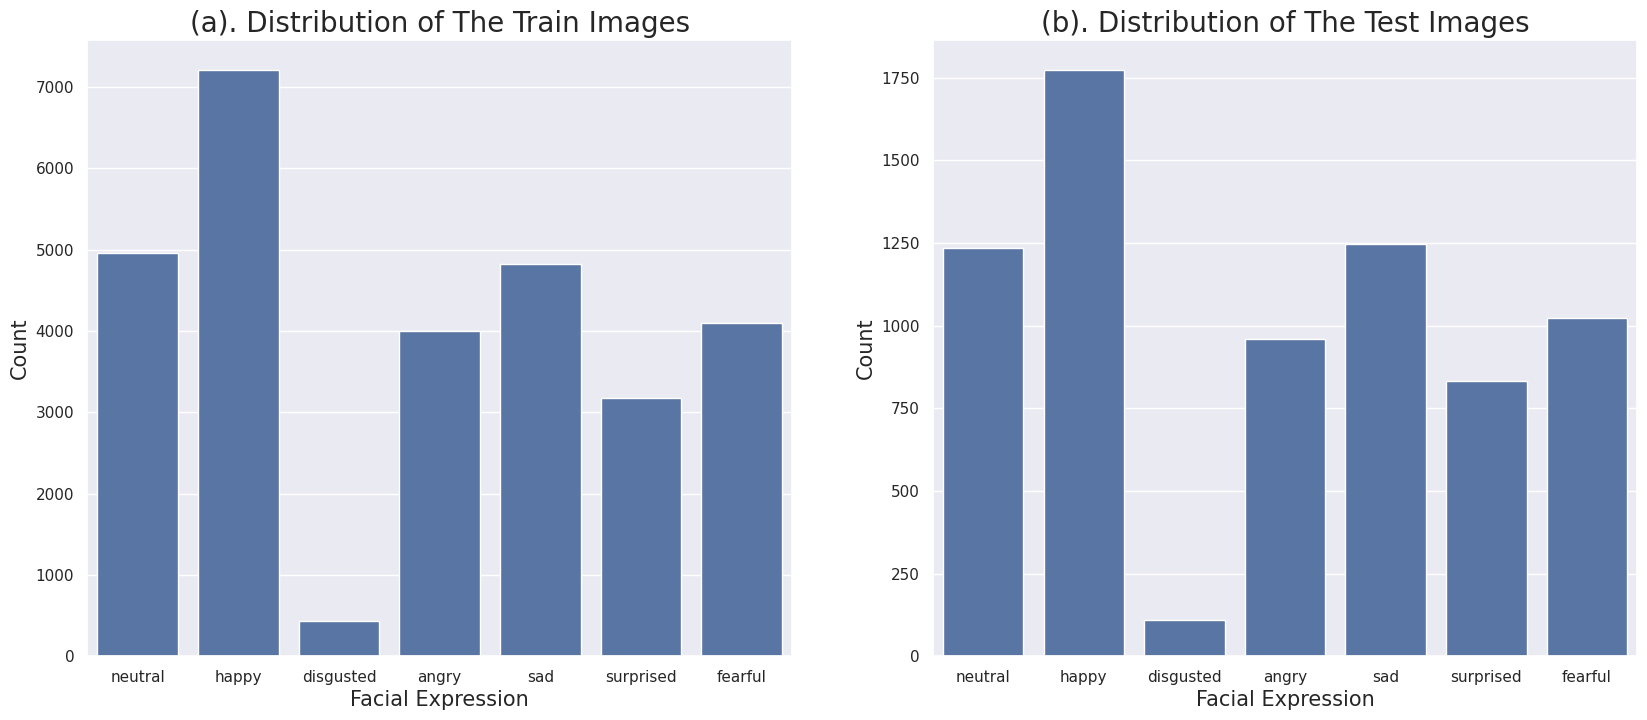

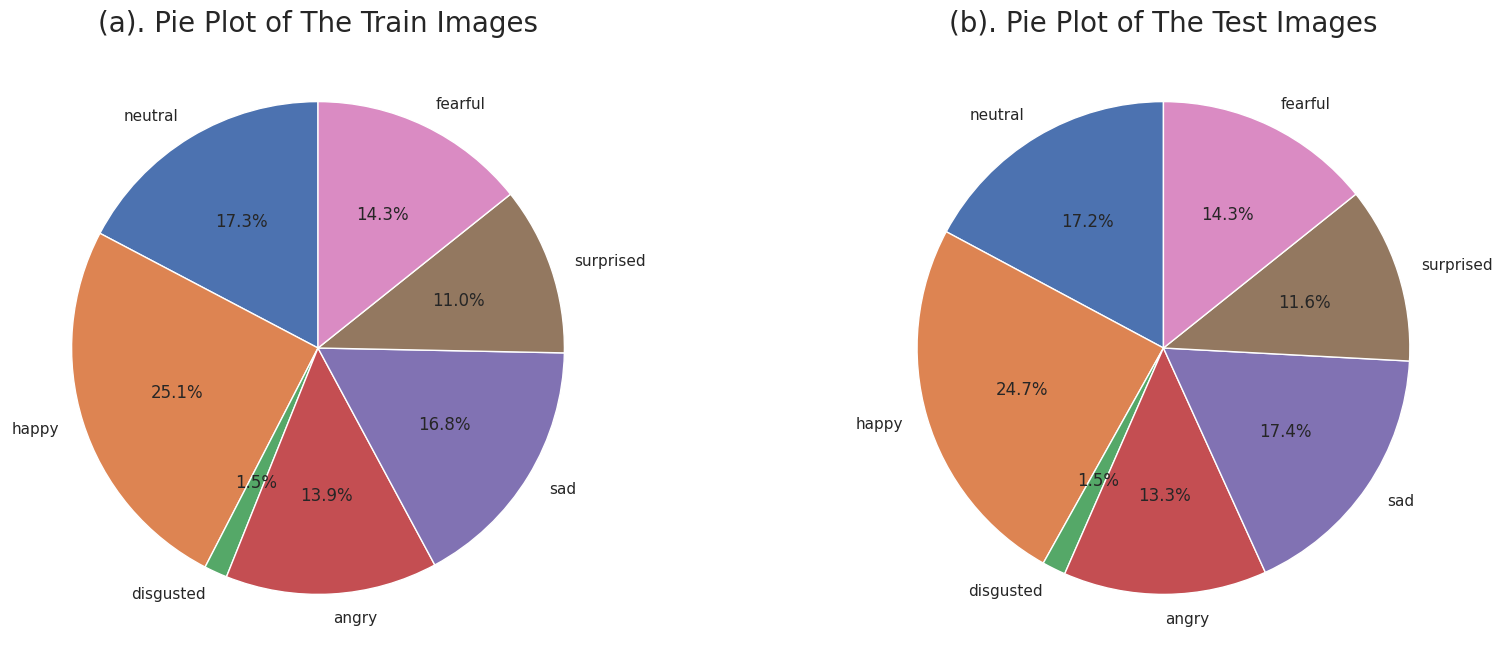

In [9]:
df_train = pds.DataFrame(list(class_sample("train")[2].items()), columns=['Emotion', 'Count'])
df_train.index.name = 'Emotion'
df_test = pds.DataFrame(list(class_sample("test")[2].items()), columns=['Emotion', 'Count'])
df_test.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
axis = sns.barplot(x='Emotion', y='Count', data=df_train, orient='v')
# set labels and title
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("(a). Distribution of The Train Images", fontsize=20)
# plt.legend( df_train.Emotion, loc='upper left')
# set x-axis tick labels
# axis.set_xticks(range(len(df_train.Emotion)), df_train.Emotion)
# axis.yaxis.set_major_locator(ticker.MultipleLocator(2.5))

plt.subplot(1, 2, 2)
sns.barplot(x='Emotion', y='Count', data=df_test, orient='v')
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("(b). Distribution of The Test Images", fontsize=20)
plt.show()

print('\n\n')

x_train = npy.array([ len(os.listdir(TRAIN_PATH+'/'+class_name+'/')) for class_name in classes])
x_test = npy.array([ len(os.listdir(TEST_PATH+'/'+class_name+'/')) for class_name in classes])
label = classes

# plot a Pie plot with vertical orientation
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
plt.pie(x_train, labels=label, autopct='%1.1f%%', startangle=90)
ax.set_title('(a). Pie Plot of The Train Images', fontsize=20)

ay = plt.subplot(1, 2, 2)
plt.pie(x_test, labels=label, autopct='%1.1f%%', startangle=90)
ay.set_title('(b). Pie Plot of The Test Images', fontsize=20)
plt.show()

Data Preprocessing

Oversampling

In [10]:
# Oversampling Technique
import os
from PIL import Image

# Define the paths to the original and oversampled dataset
train_dir = TRAIN_PATH
oversampled_dir = OVERSAMPLED_TRAIN_PATH

target_length = 7215 # highest count in a class
# target_length = 4101 Average

if not os.path.exists(oversampled_dir):
    os.mkdir(oversampled_dir)

for subfolder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = len(os.listdir(subfolder_path))
        num_duplicates = target_length // num_images
        remainder = target_length % num_images

        for i in range(num_duplicates):
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                image = Image.open(image_path)
                new_image_file = f"{i}_{image_file}"
                new_image_path = os.path.join(oversampled_dir, subfolder, new_image_file)
                if not os.path.exists(os.path.join(oversampled_dir, subfolder)):
                    os.mkdir(os.path.join(oversampled_dir, subfolder))
                image.save(new_image_path)

        if remainder != 0:
            for image_file in os.listdir(subfolder_path)[:remainder]:
                image_path = os.path.join(subfolder_path, image_file)
                image = Image.open(image_path)
                new_image_file = f"{num_duplicates}_{image_file}"
                new_image_path = os.path.join(oversampled_dir, subfolder, new_image_file)
                if not os.path.exists(os.path.join(oversampled_dir, subfolder)):
                    os.mkdir(os.path.join(oversampled_dir, subfolder))
                image.save(new_image_path)

In [11]:
# Get dictionary list of image count per class
def over_class_sample():
        filepath=OVERSAMPLED_TRAIN_PATH+'/'
        class_count = []
        class_dict ={}
        for folder in os.listdir(filepath) :
              class_count.append(len(os.listdir(filepath+folder)))
              class_dict[folder]=len(os.listdir(filepath+folder))
        class_total = sum(class_count)
        return class_total, class_count, class_dict


# test_samples=class_sample('test')[0]
# test_batch_size=sorted([int(test_samples/n) for n in range(1,test_samples+1) if test_samples % n ==0 and test_samples/n<=80],reverse=True)[0]

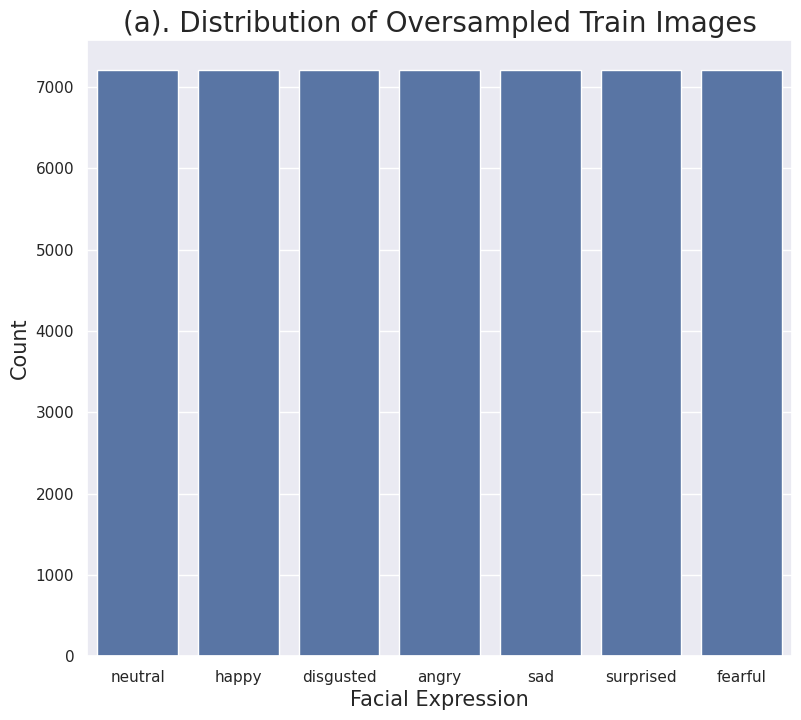


---- Oversampled Train Set ----
Train class distribution:
{'neutral': 7215, 'happy': 7215, 'disgusted': 7215, 'angry': 7215, 'sad': 7215, 'surprised': 7215, 'fearful': 7215}
Average train class:  7215
Total train:  50505


In [12]:
df_overtrain = pds.DataFrame(list(over_class_sample()[2].items()), columns=['Emotion', 'Count'])
df_overtrain.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
axis = sns.barplot(x='Emotion', y='Count', data=df_overtrain, orient='v')
# set labels and title
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("(a). Distribution of Oversampled Train Images", fontsize=20)
plt.show()



def test_train_distribution():
      print("\n---- Oversampled Train Set ----")
      avg_train=over_class_sample()[0]/len(over_class_sample()[1])
      print(f'Train class distribution:\n{over_class_sample()[2]}')
      print("Average train class: ",round(avg_train))
      print('Total train: ', over_class_sample()[0])



test_train_distribution()

Data Augmentation

In [13]:
target_size=(48, 48)
# target_size=(224, 224)
batch_size=32

## Train Image Data Generator instance.
# We will not apply any transformon specific orientations or features and no initial rescale to the image
# We'll only split the image data into train and validation set
trainValidation_data_generator = ImgDataGen(
                                            # rescale=1./225,
                                            rotation_range=10,  # Randomly rotate images by up to 10 degrees
                                            zoom_range=0.2,  # Randomly zoom images by up to 20%
                                            width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the image width
                                            height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the image height
                                            shear_range=0.2,  # Randomly apply shearing transformations
                                            horizontal_flip=True,  # Randomly flip images horizontally
                                            fill_mode='nearest',  # Fill in missing pixels with the nearest value
                                            validation_split=0.2    # set the validation split
                                            )


# Test Image Data Generator instance for Test data
test_data_generator = ImgDataGen(
                                # rescale = 1./255,
                                )



Create Train, Validation, and Test Generators

In [14]:
# Successfully mapped the train-images to their classes from the dataframe.  same for the test-images.
#  rescaling. No other transformations are applies, to preserve originality of the images.

classes = ['angry','disgusted','fearful', 'happy','neutral', 'sad', 'surprised']

## Mapping images to their classes.
print('Train Set Generated - ',end=' ')
train_generator = trainValidation_data_generator.flow_from_directory(
                                                            directory=OVERSAMPLED_TRAIN_PATH,
                                                            # directory=TRAIN_PATH,
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical',
                                                            color_mode='rgb',
                                                            classes=classes,
                                                            shuffle=True,
                                                            subset='training' # set as training data
                                                        )
## Mapping images to their classes.
print('Validation Set Generated - ',end=' ')
validation_generator = trainValidation_data_generator.flow_from_directory(
                                                            # directory=TRAIN_PATH,
                                                            directory=OVERSAMPLED_TRAIN_PATH,
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical',
                                                            color_mode='rgb',
                                                            classes= classes,
                                                            shuffle=False,
                                                            subset='validation' # set as validation data
                                                        )
test_samples=class_sample('test')[0]
test_batch_size=batch_size
test_steps=int(test_samples/test_batch_size)

## Mapping images to their classes.
print('Test Set Generated - ',end=' ')
test_generator = test_data_generator.flow_from_directory(
                                        directory=TEST_PATH,
                                        target_size=target_size,
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        classes=classes,
                                        shuffle=False,
                                        batch_size=test_batch_size
                                        )

## Mapping shuffled images to their classes.
print('Shuffled Test Set Generated - ',end=' ')
test_generator_shuffled = test_data_generator.flow_from_directory(
                                        TEST_PATH,
                                        target_size=target_size,
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        classes=classes,
                                        shuffle=True,
                                        batch_size=test_batch_size
                                        )


Train Set Generated -  Found 40404 images belonging to 7 classes.
Validation Set Generated -  Found 10101 images belonging to 7 classes.
Test Set Generated -  Found 7178 images belonging to 7 classes.
Shuffled Test Set Generated -  Found 7178 images belonging to 7 classes.


More on Data Analysis

In [15]:
# From the generator we can get information we will need later
# classes=  # os.listdir(TRAIN_PATH+'/')
class_dictionary = train_generator.class_indices
class_keys = list(train_generator.class_indices.keys())
class_values = list(train_generator.class_indices.values())
class_count = len(class_keys)

print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)
test_images, test_labels = next(test_generator)

print(f'\nThere are 7 classes: {classes}')
print(f'The class dictionary are: {class_dictionary}')
print('Class count: ', class_count)

print('\nX_train shape: ', train_images.shape)
print('y_train shape: ', train_labels.shape)
print('\nX_test shape: ', test_images.shape)
print('y_test shape: ', test_labels.shape)

print('\ntrain_generator sample: ', train_generator.samples)
print('validation_generator sample: ', validation_generator.samples)
print('test_generator sample: ', test_generator.samples)

print('\ntrain_generator sample: ', train_generator.labels)
print('validation_generator sample: ', validation_generator.labels)
print('test_generator sample: ', test_generator.labels)


test batch size:  32   test steps:  224  number of classes :  7

There are 7 classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
The class dictionary are: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Class count:  7

X_train shape:  (32, 48, 48, 3)
y_train shape:  (32, 7)

X_test shape:  (32, 48, 48, 3)
y_test shape:  (32, 7)

train_generator sample:  40404
validation_generator sample:  10101
test_generator sample:  7178

train_generator sample:  [0 0 0 ... 6 6 6]
validation_generator sample:  [0 0 0 ... 6 6 6]
test_generator sample:  [0 0 0 ... 6 6 6]


In [16]:
class_indices = train_generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices}
num_images = train_generator.samples

batch_size = train_generator.batch_size
num_batches = len(train_generator)

for i in range(num_batches):
    batch = next(train_generator)
    images, labels = batch
    for j in range(len(labels)):
        label = npy.argmax(labels[j])  # convert one-hot encoding to integer label
        class_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        class_counts[class_name] += 1

print(class_counts)
print(f"Total number of images in train generator: {num_images}")
{'angry': 5773, 'fearful': 5770, 'happy': 5771, 'sad': 5774, 'surprised': 5772}


{'angry': 5770, 'disgusted': 5775, 'fearful': 5773, 'happy': 5775, 'neutral': 5770, 'sad': 5771, 'surprised': 5770}
Total number of images in train generator: 40404


{'angry': 5773, 'fearful': 5770, 'happy': 5771, 'sad': 5774, 'surprised': 5772}

More on Data Visualization

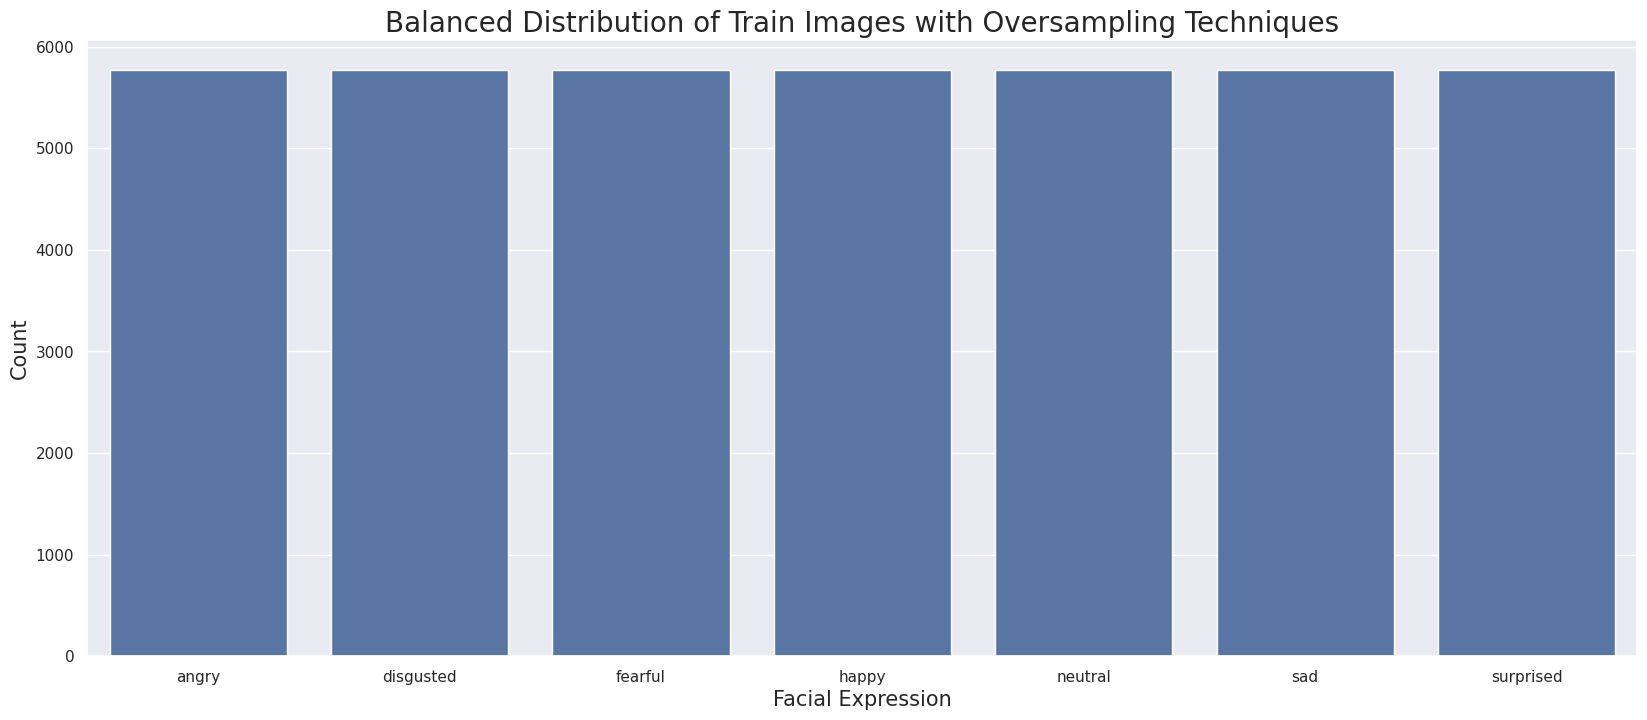

In [17]:
df_train_gen = pds.DataFrame(list(class_counts.items()), columns=['Emotion', 'Count'])
df_train_gen.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(20, 8))
sns.barplot(x='Emotion', y='Count', data=df_train_gen, orient='v')
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Balanced Distribution of Train Images with Oversampling Techniques", fontsize=20)
plt.show()


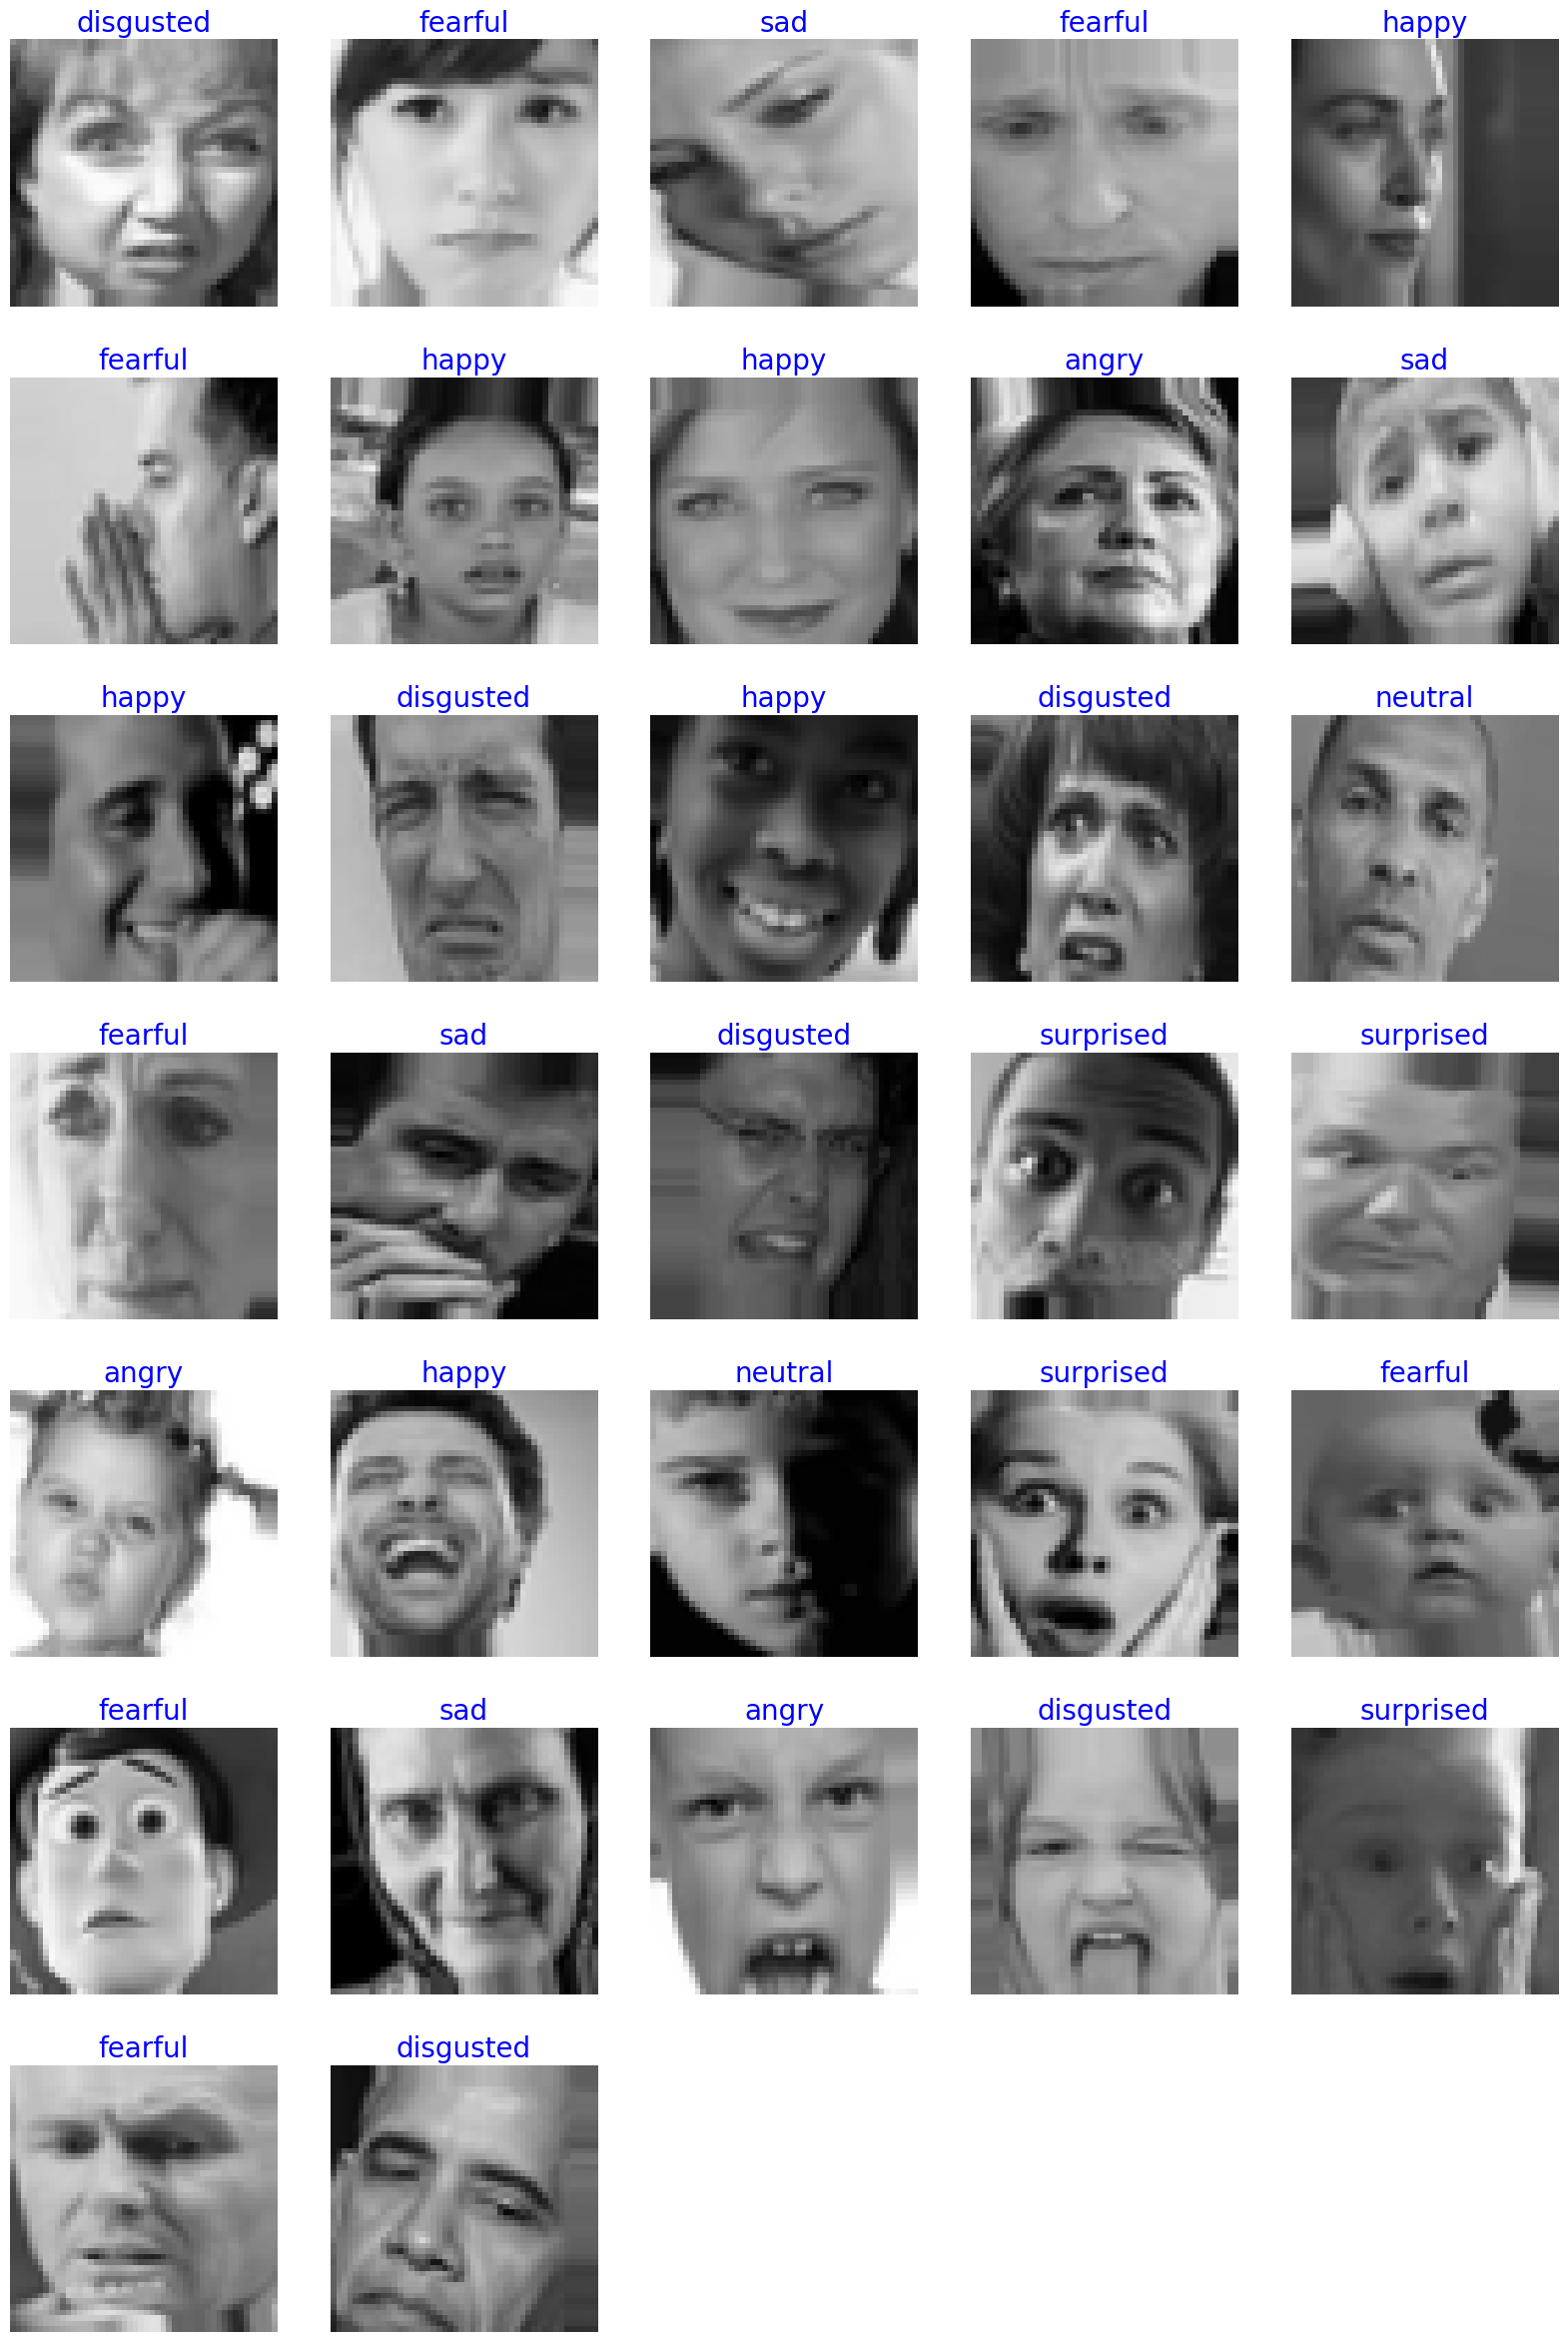

In [18]:
# Get the sample images, labels, and their filenames
# To get the correct filename, turn off the shuffle
def plotImageWithNames(gen):
    images, labels = next(gen)
    filenames = gen.filenames
    classes = list(gen.class_indices.keys())

    plt.figure(figsize=(20, 30))
    length=len(labels)
    if length<32:
        r=length
    else:
        r=32
    for i in range(r):
        plt.subplot(7, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=npy.argmax(labels[i])
        class_name=classes[index]
        filename=gen.filenames[i]
        plt.title(
                    label=f"{class_name}", # \n{filename} ",
                    color='blue',
                    fontsize=20
                    )
        plt.axis('off')
    plt.show()

plotImageWithNames(train_generator)

Model Development

In [19]:
from tensorflow import keras
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras import layers, optimizers, metrics, regularizers, models
from tensorflow.keras.optimizers import Adam, Adamax
# from tensorflow.keras.metrics import categorical_crossentropy, sparse_categorical_crossentropy

In [20]:
# define the image shape for the input layer
input_shape=(target_size[0], target_size[1], 3)
batch_size = batch_size
epochs=15
ask_epoch=15

Model Building and Compiling

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(
                                                            include_top=False,
                                                            weights="imagenet",
                                                            input_shape=input_shape,
                                                            pooling='max'
                                                            )

# Let's make our base_model trainable to get better results
base_model.trainable=True
x=base_model.output

x=BatchNormalization(
                    axis=-1,
                    momentum=0.99,
                    epsilon=0.001,
                    name='batch_norm_x'
                    )(x)
x = Dense(
          256,
          kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu',
          name='dense_x'
          )(x)

x=Dropout(
          rate=.4,
          seed=123,
          name='dropout_x'
          )(x)

output=Dense(
            class_count,
            activation='softmax',
            name='dense_output'
            )(x)
cnn_model=Model(inputs=base_model.input, outputs=output, name=model_name)
learning_rate=.001 # start with this learning rate
cnn_model.compile(
                  Adamax(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                  )

# View the model summary
cnn_model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "EfficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 48, 48, 3)            0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 48, 48, 3)            7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

In [22]:
!pip install keras


In [23]:
!apt-get install -y graphviz libgraphviz-dev
!pip install pydot graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:

In [24]:
!pip install tensorflow

In [25]:
from tensorflow.keras.utils import plot_model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.75985 to fit



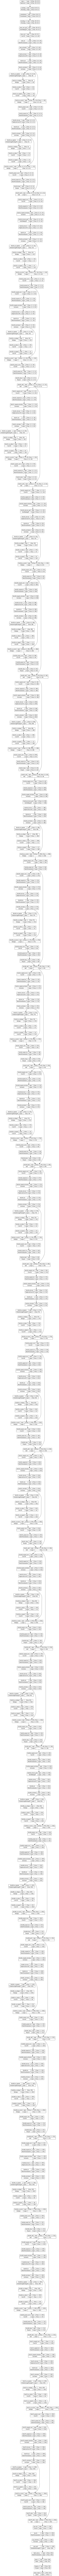

In [26]:
from tensorflow.keras.utils import plot_model

# Assuming cnn_model is Keras model
plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Create a Custom Keras Callback to Continue or Halt Training

In [27]:

class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.subask_epoch = int(ask_epoch/2)
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch

    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to')
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch

        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou earlier specified a maximum epochs of ', self.epochs, '\n, its seems that you want to train for a total of', self.ask_epoch,'\n\n Please confirm your action, please enter "Y", or "N" to end training at ', self.epochs)
                        ans=input()

                        if ans == 'Y' or ans =='y':
                            self.epochs = self.ask_epoch
                        else:
                             print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

ask=ASK(cnn_model, epochs,  ask_epoch)

Checkpoint Callback

Checkpoint 1: Save Weight Only
Creates a single collection of TensorFlow checkpoint files that are updated at the end of each epoch.

As long as two models share the same architecture, the weights between them can be shared. So, when restoring a model from weights-only, create a model with the same architecture as the original model and then set its weights.

In [28]:
# starting the Checkpoint for the model
# checkpoint_dir = os.path.dirname(checkpoint_path)

check_point = tf.keras.callbacks.ModelCheckpoint(
                                          filepath=checkpoint_path(model_name),
                                          save_weights_only=True,
                                          save_best_only=True,
                                          monitor="val_accuracy",
                                          verbose = 1,
                                        )

reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_accuracy",
                                            # factor=0.5,
                                            patience=2,
                                            verbose=1
                                            )

early_stop = tf.keras.callbacks.EarlyStopping(
                                       monitor="val_accuracy",
                                       min_delta=0.0005,
                                       patience=11,
                                       verbose=1,
                                       restore_best_weights=True
                                       )

callbacks = [
            check_point,
            reduce_learning,
            early_stop,
            ask
          ]

Model Training

In [29]:
model_history=cnn_model.fit(
                  train_generator,
                  steps_per_epoch=train_generator.n//train_generator.batch_size,
                  epochs=15,
                  verbose=1,
                  callbacks=callbacks,
                  validation_data=validation_generator,
                #   validation_steps=None,
                  validation_steps= validation_generator.n//validation_generator.batch_size,
                #   validation_data=test_generator,
                # #   validation_steps=None,
                #   validation_steps= test_generator.n//test_generator.batch_size,
                #   # shuffle=True,
                  )

ask_epoch >= epochs, will train for  15  epochs
Training will proceed until epoch 15  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/15
1262/1262 [==============================] - ETA: 0s - loss: 4.9292 - accuracy: 0.3075
Epoch 1: val_accuracy improved from -inf to 0.44395, saving model to models/fedav_best_model-EfficientNetB3.ckpt
1262/1262 [==============================] - 217s 124ms/step - loss: 4.9292 - accuracy: 0.3075 - val_loss: 2.3827 - val_accuracy: 0.4439 - lr: 0.0010
Epoch 2/15
1262/1262 [==============================] - ETA: 0s - loss: 1.8501 - accuracy: 0.4624
Epoch 2: val_accuracy improved from 0.44395 to 0.53462, saving model to models/fedav_best_model-EfficientNetB3.ckpt
1262/1262 [==============================] - 153s 121ms/step - loss: 1.8501 - accuracy: 0.4624 - val_loss: 1.4588 - val_accuracy: 0.5346 - lr: 0.0010
Epoch 3/15
1262/1262 [==============================] - ETA: 0s -

In [40]:
model_history=cnn_model.fit(
                  train_generator,
                  steps_per_epoch=train_generator.n//train_generator.batch_size,
                  epochs=50,
                  verbose=1,
                  callbacks=callbacks,
                  validation_data=validation_generator,
                #   validation_steps=None,
                  validation_steps= validation_generator.n//validation_generator.batch_size,
                #   validation_data=test_generator,
                # #   validation_steps=None,
                #   validation_steps= test_generator.n//test_generator.batch_size,
                #   # shuffle=True,
                  )

ask_epoch >= epochs, will train for  15  epochs
Training will proceed until epoch 15  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/50
1262/1262 [==============================] - ETA: 0s - loss: 0.7930 - accuracy: 0.7631
Epoch 1: val_accuracy improved from 0.72808 to 0.73829, saving model to models/fedav_best_model-EfficientNetB3.ckpt
1262/1262 [==============================] - 155s 122ms/step - loss: 0.7930 - accuracy: 0.7631 - val_loss: 0.8557 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 2/50
1262/1262 [==============================] - ETA: 0s - loss: 0.7608 - accuracy: 0.7757
Epoch 2: val_accuracy improved from 0.73829 to 0.74762, saving model to models/fedav_best_model-EfficientNetB3.ckpt
1262/1262 [==============================] - 143s 114ms/step - loss: 0.7608 - accuracy: 0.7757 - val_loss: 0.8257 - val_accuracy: 0.7476 - lr: 0.0010
Epoch 3/50
1262/1262 [==============================] - ETA: 0

Accuracy and Loss Function Graph

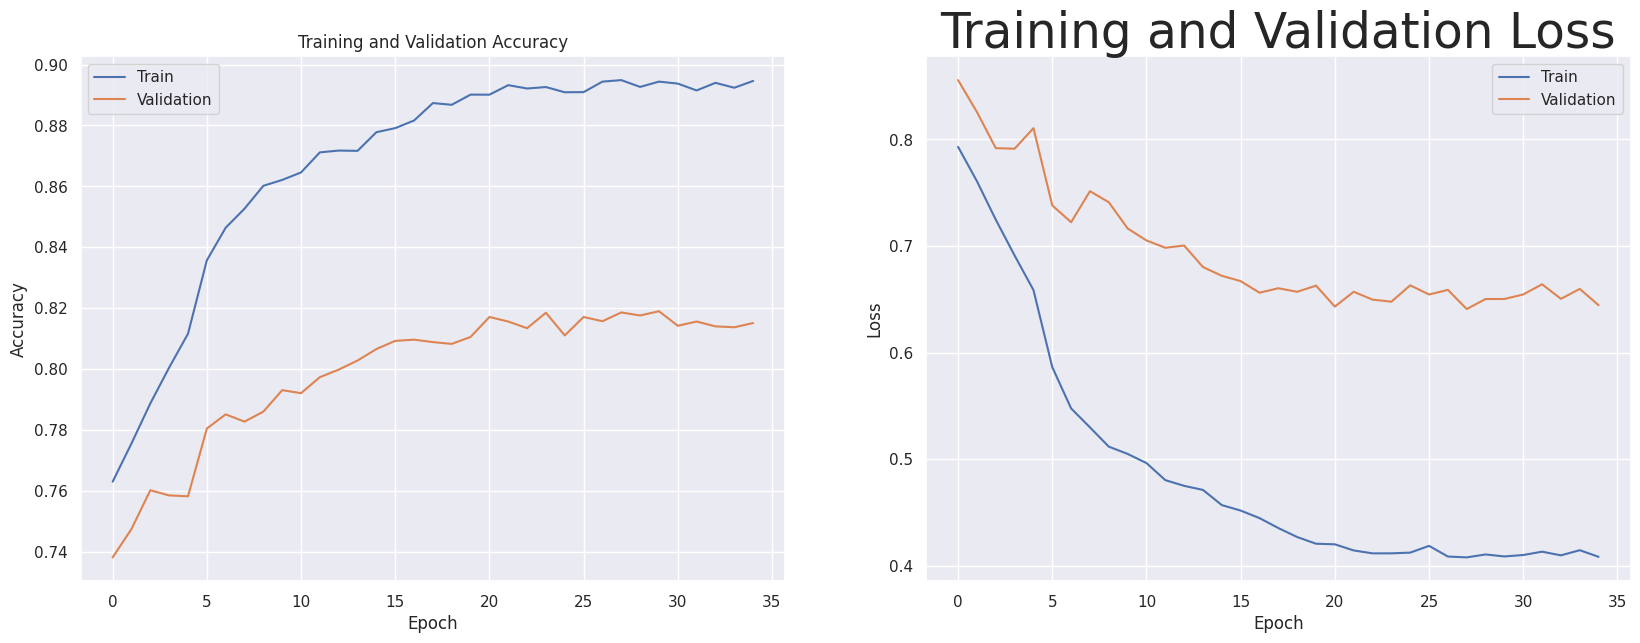

In [41]:
from pylab import rcParams
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
start_epoch = 0
Epoch_count=len(acc)+ start_epoch
Epochs=[]
for i in range (start_epoch ,Epoch_count):
    Epochs.append(i+1)
index_loss=npy.argmin(val_loss)   #   this is the epoch with the lowest validation loss
val_lowest=val_loss[index_loss]
index_acc=npy.argmax(val_acc)


# summarize history for accuracy using reLU
sns.set()
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



# summarize history for loss using reLU
plt.subplot(2, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss', fontsize=35)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


Model Evaluation

In [42]:
# Loads the weights
cnn_model.load_weights(checkpoint_path(model_name=model_name))

# Re-evaluate the model
loss, acc = cnn_model.evaluate(validation_generator, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))


316/316 - 16s - loss: 0.6433 - accuracy: 0.8202 - 16s/epoch - 49ms/step
Restored model, validation accuracy: 82.02%


Prediction on Test Images

316/316 [==============================] - 15s 48ms/step
total prediction: 10101

1854 out of 10101 tested images could not be detected properly.
Accuracy of  81.65



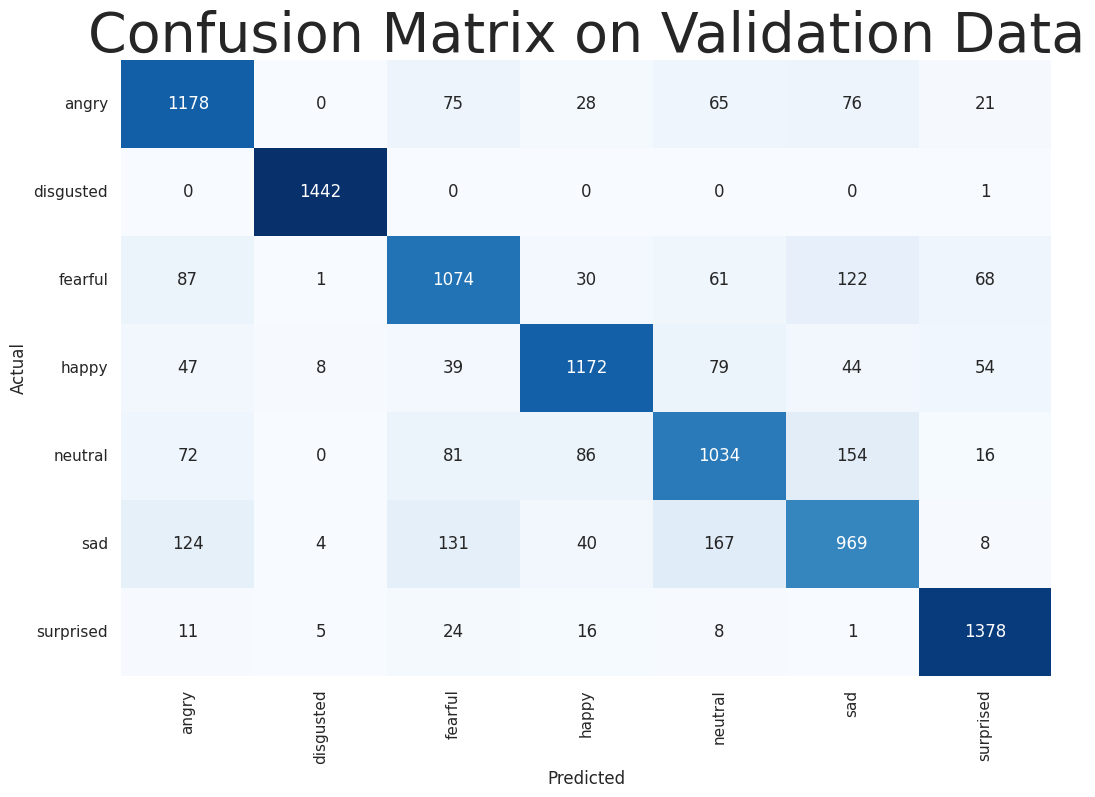

Classification Report on Validation Data:
-------------------------------------
               precision    recall  f1-score   support

       angry    0.77551   0.81635   0.79541      1443
   disgusted    0.98767   0.99931   0.99346      1443
     fearful    0.75421   0.74428   0.74922      1443
       happy    0.85423   0.81220   0.83268      1443
     neutral    0.73126   0.71656   0.72384      1443
         sad    0.70937   0.67152   0.68993      1443
   surprised    0.89133   0.95495   0.92205      1443

    accuracy                        0.81645     10101
   macro avg    0.81480   0.81645   0.81522     10101
weighted avg    0.81480   0.81645   0.81522     10101



In [44]:
#
def ModelPredictionOnTestDataset(test_generator):
#     test_steps= test_generator.n//test_generator.batch_size
    y_pred= []
    y_label=test_generator.labels
    classes=list(train_generator.class_indices.keys())
    class_count=len(classes)
    wrong_predictions=0

    # predict on the test set
    preds=cnn_model.predict(test_generator, test_steps, verbose=1)

    total_predictions=len(preds)
    print(f'total prediction: {total_predictions}')
    for i, p in enumerate(preds):
            pred_index=npy.argmax(p)
            # labels are integer values
            true_index=test_generator.labels[i]
            if pred_index != true_index:
                # a misclassification has occurred
                wrong_predictions=wrong_predictions + 1
            y_pred.append(pred_index)
    acc=( 1-wrong_predictions/total_predictions) * 100
    print(f'\n{wrong_predictions} out of {total_predictions} tested images could not be detected properly.\nAccuracy of {acc:6.2f}\n')
    ypred=npy.array(y_pred)
    ytrue=npy.array(y_label)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(npy.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(npy.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix on Validation Data", fontsize=40)
        plt.show()
    clr = classification_report(y_label, y_pred, target_names=classes, digits= 5) # create classification report
    print("Classification Report on Validation Data:\n-------------------------------------\n", clr)

#     # Plot the confusion matrix
#         ConfusionMatrix(
#                         label_test=ytrue,
#                         label_prep=ypred,
#                         class_count=class_count,
#                         class_keys=class_keys,
#                         heada=' for Entire Test Set'
#                         )

    return wrong_predictions, total_predictions

wrong_predictions, total_predictions = ModelPredictionOnTestDataset(validation_generator)

Prediction on Test Images

1/1 [==============================] - 0s 31ms/step
correct prediction: 0.78125


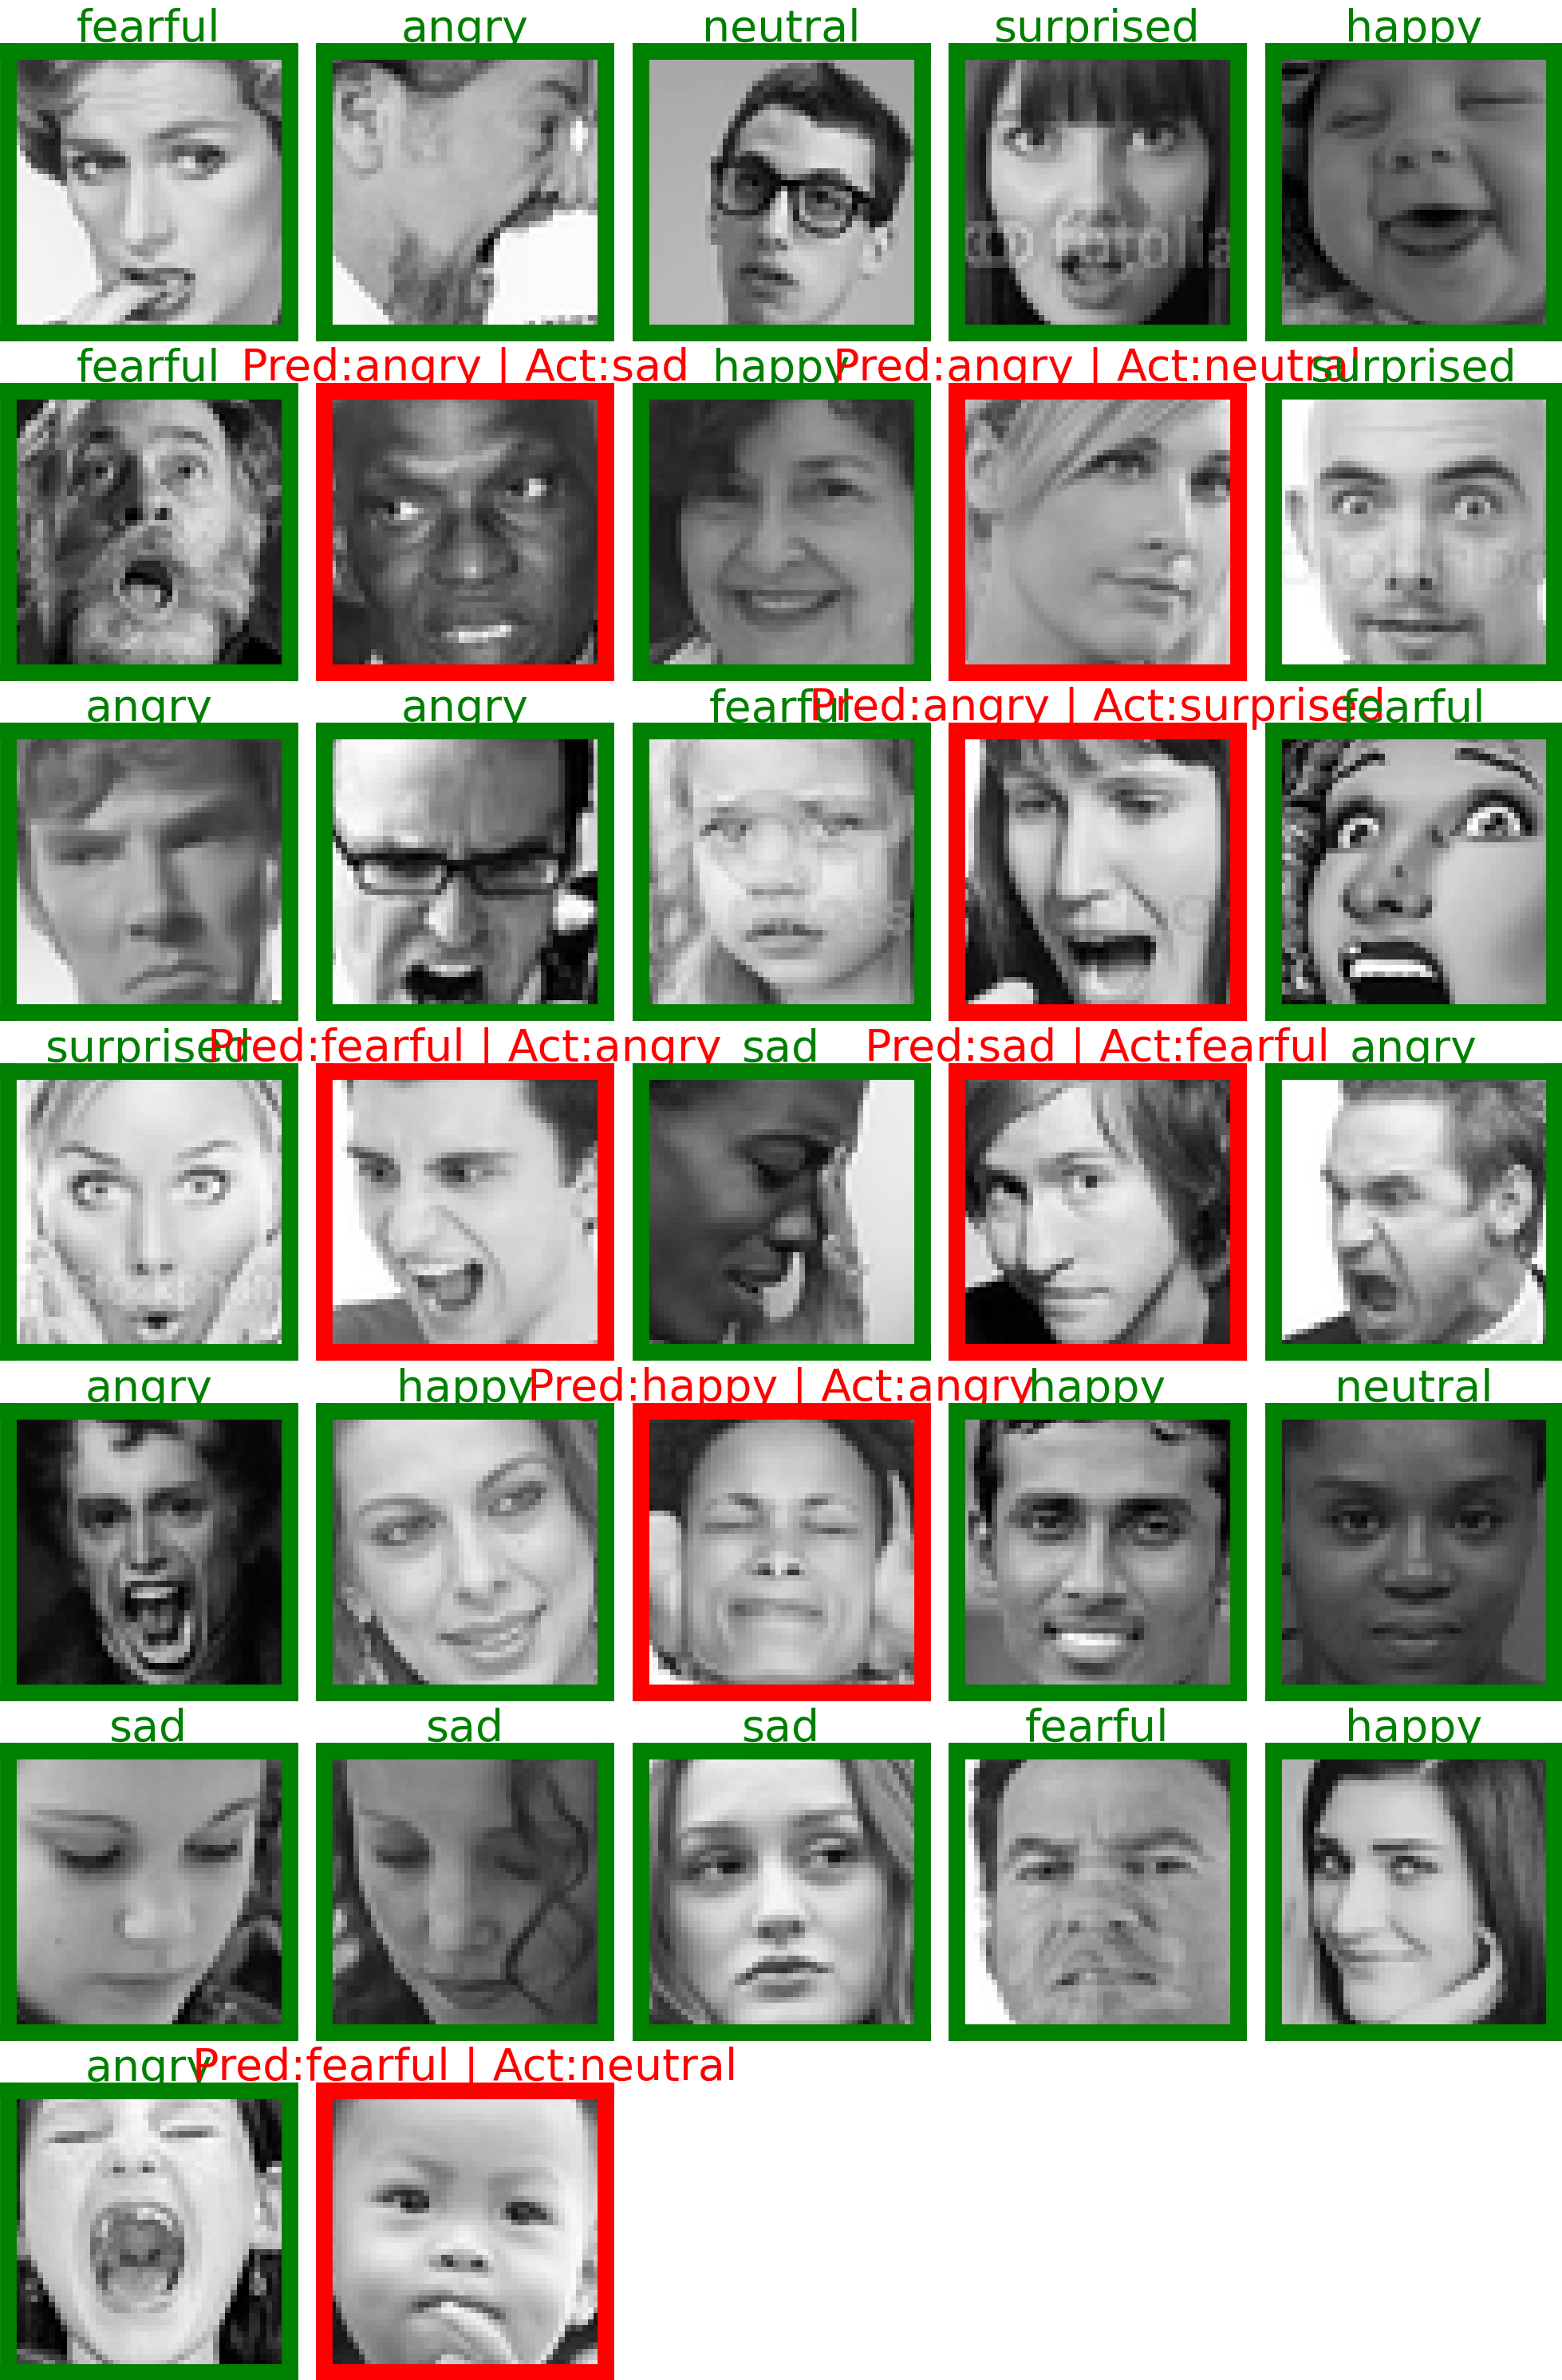

In [48]:
test_images, test_labels = next(test_generator_shuffled)
preds = cnn_model.predict(test_images)
# print(preds)
idx = npy.argmax(preds, axis = 1)
# test_labels = test_labels.astype(int)
test_labels = npy.argmax(test_labels, axis = 1)
idx = idx.reshape((-1, 1))
test_labels = npy.reshape(test_labels, (len(test_labels), 1))
# print()
print('correct prediction:', npy.sum((test_labels == idx)*1)/test_batch_size)


def compare(idx, train_generator):
    class_dictionary = train_generator.class_indices
    for key, value in class_dictionary.items():
        if value == idx:
             return key

def dif(test_labels, idx, train_generator):
    class_dictionary = train_generator.class_indices
    test = ''
    id = ''
    for key, value in class_dictionary.items():
        if value == test_labels:
            test = key
        if value == idx:
            id = key
    return test, id



fig = plt.figure(figsize=((20, 30)))

# k = 0
for j in range(len(idx)):
    ax = plt.subplot(7, 5, j+1)
    px = test_images[j]/255
#     k += 1
    ax.imshow(px)
    ax.set_xticks([])
    ax.set_yticks([])

#     print(idx[j])
#     print(test_labels[j])
    if test_labels[j] == idx[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('green')
        ax.set_title(
                    compare(idx[j], train_generator),
                    color='green',
                    fontsize=40
                     )

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('red')
        ax.set_title(
                    'Pred:'+dif(test_labels[j], idx[j], train_generator)[1]+" | Act:"+ dif(test_labels[j], idx[j], train_generator)[0],
                    color='red',
                    fontsize=40
                    )
    plt.tight_layout()